**Содержание темы**

1. Теория
2.  [Практический ноутбук 1](https://colab.research.google.com/drive/1fchXLLvAmJweE3kB00xJQazp2DiA_2Be?usp=sharing)
3. [Практический ноутбук 2](https://colab.research.google.com/drive/16lyctI5oJzVhVC3nQmIIs0tzFRPFPAk_?usp=sharing)

На прошлом уроке мы изучили основы Q-learning — обучения с подкреплением. В этом уроке мы углубимся в тему и рассмотрим градиентную политику.

## Градиентная политика

Школа алгоритмов, у которых есть общие принципы. Противоположна Q-learning.

**Основное отличие от Q-learning** — прямое воздействие на веса и отсутствие в расчетах `Q(s,a)`.

В контексте изучаемого материала, политика — вес НС, а градиентная политика — использование градиентного спуска, чтобы менять политику агента в лучшую сторону при обучении.

Политика бывает двух видов:
* **Детерминированная** — предсказывает само действие.
* **Стохастическая** — предсказывает вероятность принятия действия, а не само действие.

Стохастический тип политики чаще используют при обучении НС, так как он позволяет агенту исследовать пространство.

>Рассмотрим пример, чтобы понять разницу между детерминированной и стохастической политиками. Возьмем агента, изучающего лабиринт и стоящего в коридоре, где можно двигаться либо вперед, либо назад. 

Стохастическая политика скажет о том, что 90% вероятность идти вперед и 10% — назад. При определенном стечении обстоятельств агент пойдет назад. 

Детерминированная политика тоже предскажет эти же вероятности. Однако при помощи `argmax()` или других инструментов будет всегда выбираться действие «вперед». Шанса у действия «назад» нет. Это может привести к тому, что выход из лабиринта будет найден нескоро, если он был в паре шагов за спиной у агента.

##Сравнение Q-обучения и градиентной политики

 **Q-обучение**
* Алгоритм (нейросеть) принимает на вход состояние и предсказывает возможные значения, т. е. `Q(s, a)`, за разные действия. 
* Исследование среды происходит через метод Epsilon-Greedy (есть вероятность `e` принять рандомное действие).
* Часто отмечается, что алгоритм хорошо справляется с видеоиграми или задачами, где мало уникальных действий (маленькое пространство действий).
* Для обучения работоспособного алгоритма нужны две нейронные сети (основная и целевая).
* Алгоритму требуется буфер памяти, чтобы избежать переобучения. Модель обучается на тех же данных много раз.
* Обучение модели может происходить в любой момент, необязательно после окончания игры.
* Часто использует небольшой размер пакета (`batch size ~= 32-128`, но это зависит от задачи).
* Алгоритм не требует предобработки наград. Нейронная сеть сама учится использовать уравнение Беллмана.

**Градиентная политика**
* Алгоритм (нейросеть) сразу предсказывает нужное действие 
через состояние.
* Обычно предсказывается вероятность выбора действия вместо самого действия. Это делается для того, чтобы алгоритм исследовал среду во время обучения. 
* Алгоритм лучше обучается на задачах, где много возможных действий (большое пространство действий).
* У алгоритма всего одна нейронная сеть, вторая здесь не нужна.
* У алгоритма не может быть буфера памяти, т. к. он должен обучаться на всех данных только один раз. 
* Алгоритм должен обновлять свою политику (веса) только один раз после получения новых данных. Это значит, что нужно использовать метод `train_on_batch()` для обучения вместо `.fit()`. Чуть позже мы узнаем, почему это так.
* Обучение должно происходить в конце эпизода — после прохождения в конечное состояние среды (или хотя бы в конечное состояние с ненулевой наградой).
* Награды нужно предобработать определенным образом. Метод предобработки будет немного отличаться в зависимости от задачи (скудные награды или постоянные награды).
* Политические алгоритмы сразу обучаются на всем эпизоде данных, что открывает дополнительные возможности. Например, можно увеличивать награду в конце эпизода, если эпизод длится дольше или короче.



## Алгоритм REINFORCE 

*(REward Increment = Non-negative Factor x Offset REINFORCEment x Characteristic Eligibility)* — полная противоположность Q-обучению, при этом слабее него. Он намного проще и хорошо решает простые задачи. Это стартовый алгоритм для обучения и познания более сложных политических алгоритмов, которые сильнее в решении задач, чем Q-обучение.

Одно из условий успешного обучения с подкреплением — это награды. При этом неважно, за что они выдаются: за действие или за весь эпизод, за время эпизода или количество забитых мячей. Поэтому награды необходимо приводить в формат, понятный для НС.

Чаще всего награды выдаются за результат игры или действия. В первом случае сложно оценить, какие именно действия привели к этому результату. Так же как и награда за какое-либо действие не всегда ведет к тому, что агент выиграет.

Для примера возьмем шахматы и шашки. Если в шахматах выдавать награду за взятые вражеские фигуры, то можно взять много фигур, но все равно потерять короля. Такая же система успешно работает в шашках, но бывают ситуации, когда одна потерянная шашка приводит к поражению. С другой стороны, награда за победу в шахматах не показывает, насколько успешны были ходы до победы.

По этой причине данные о наградах необходимо предобработать, чтобы действия, предшествующие награде, тоже были отмечены как важные.

Сценарий со скудными наградами соответствует наградам за победу/проигрыш в игре. Чтобы НС могла определять, что предыдущие действия тоже влияли на получение награды, награда распределяется на все действия до этого.

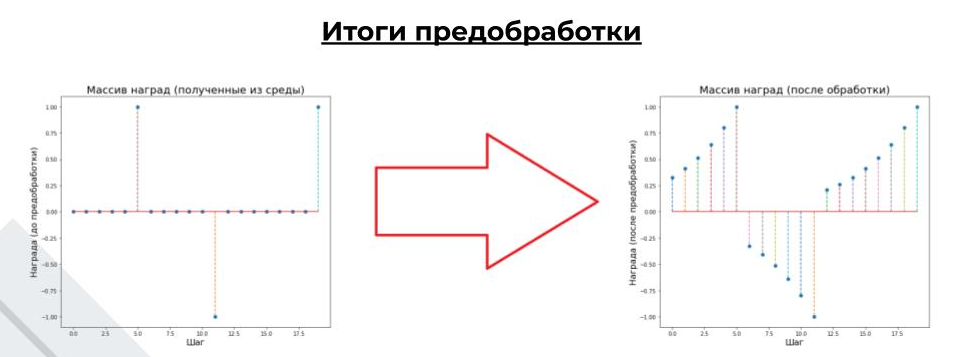

Противоположный предыдущему сценарию — сценарий непрерывных наград. Награды выдаются за каждое действие. Здесь предобработка состоит в том, что все действия взвешиваются относительно конечного результата и идут накопительным эффектом. 

Например, если взяли пешку противника, нам выдали 1 единицу награды. Но на следующем ходу мы потеряли ферзя и получили награду -4. В результате предобработки награды выстроятся так: +1, -3 и так далее. То есть на следующий ход после потери ферзя мы будем находиться в неприятной ситуации. Если бы взяли две пешки подряд, то после второго хода награда была бы равна 2.

Теперь, когда НС понимает, какие действия могут привести к победе, а какие к поражению, необходимо разобраться в особенностях обучения.

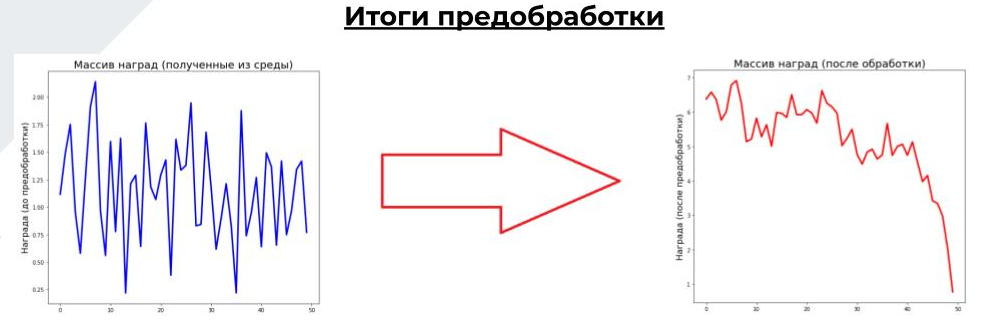

Особенности обучения в соответствии с политикой заключаются в том, что:
1. Обучение может проходить только на данных, полученных от этой политики.
2. Данные, которые уже были использованы для обучения, очень нежелательно использовать повторно.
3. Обучать можно только на полном цикле игры, обучение в середине игры не подходит.
4. Обучение при помощи `model.fit` может создать проблемы для НС, так как при данном методе обучения из всей игры берутся несколько состояний и объединяются в один пакет. В игре можем иметь дело со скудными наградами в одинаковых состояниях, когда одинаковые действия могут иметь разные награды. 
5. Обучение при помощи `model.train_on_batch` не поделит эпизод на состояния и будет считать ошибкой на протяжении всей игры. Только после этого НС обновит веса.

Остановимся еще на некоторых особенностях алгоритмов:
* Награды нужно нормировать, так как НС любят работать с значениями от 0 до 1. Но на некоторых ресурсах предлагают приводить награды к стандартному распределению. Это может дать отрицательный эффект в обучении НС, так как некоторые действия будут вести к победе. Однако при таком распределении им будет назначаться отрицательная награда, так как возможно есть лучшие действия. 
* Алгоритм REINFORCE имеет достаточно много недостатков: невозможность выучить оптимальную политику и решать сложные задачи, невысокая стабильность. Однако он прост в изучении и дает возможность изучать другие алгоритмы.

Теперь мы можем узнать, где можно самостоятельно применять алгоритм.

Алгоритмы созданы не только для игр, но и для решения практических задач,  например при трейдинге, составлении расписания и так далее. Для этого необходимо написать собственную среду, аналогичную GymAI, что требует достаточно глубоких знаний в программировании. Поэтому в практической части мы рассмотрим уже готовую среду.

**Содержание темы**

1. Теория
2.  [Практический ноутбук 1](https://colab.research.google.com/drive/1fchXLLvAmJweE3kB00xJQazp2DiA_2Be?usp=sharing)
3. [Практический ноутбук 2](https://colab.research.google.com/drive/16lyctI5oJzVhVC3nQmIIs0tzFRPFPAk_?usp=sharing)